# Phase 2: Zooplankton Dynamics in a CA Environment

## Aim
The objective of this notebook is to analyze the population dynamics of a single species, `Zooplankton`, within the new, more realistic Cellular Automata (CA) environment. We will:
1. Set up a dynamic environment where the food source (plankton) is governed by CA rules of diffusion and growth.
2. Spawn a population of Zooplankton agents.
3. Run the simulation using the high-performance, vectorized `SimulationManager`.
4. Collect and visualize data to analyze the emergent boom-and-bust cycle in this more complex system.

## Setup
We set up the system path and import all necessary classes and functions.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.environment import Environment
from src.agents.zooplankton import Zooplankton
from src.agents.behaviors import RandomWalk
from src.utils.config_loader import load_fauna_config, load_sim_config
from src.simulation.simulation_manager import SimulationManager

print("Setup complete. Modules imported successfully.")

Setup complete. Modules imported successfully.


## Simulation Configuration
We load the central configuration files. For this experiment, we will focus only on the Zooplankton and the environment.

In [2]:
sim_config = load_sim_config()
fauna_configs = load_fauna_config()
zooplankton_config = fauna_configs["Zooplankton"]

print("--- Simulation Parameters ---")
pprint(sim_config)
print("\n--- Zooplankton Parameters ---")
pprint(zooplankton_config)

--- Simulation Parameters ---
{'disease_chance': 0.43268394637424534,
 'disease_threshold': 5,
 'grid_depth': 15,
 'grid_height': 50,
 'grid_width': 50,
 'initial_food_density': 0.7,
 'initial_small_fish_count': 5,
 'initial_zooplankton_count': 50,
 'plankton_diffusion_rate': 0.05,
 'plankton_max_growth_rate': 0.1,
 'simulation_ticks': 500}

--- Zooplankton Parameters ---
{'carrying_capacity_threshold': 1,
 'eating_rate': 0.5,
 'energy_conversion_factor': 5.0,
 'initial_energy': 10.0,
 'max_density_per_cell': 5,
 'metabolic_rate': 0.1,
 'movement_cost': 0.2,
 'reproduction_threshold': 18.0,
 'size': 1.0,
 'species_name': 'Zooplankton',
 'starvation_chance': 0.5}


## Simulation Run
This cell contains the main simulation loop. It initializes the environment and agents, then iterates through each tick using the `SimulationManager`, recording key metrics for later analysis.

In [3]:
# --- 1. Setup ---
env = Environment(
    sim_config['grid_width'], 
    sim_config['grid_height'], 
    sim_config['grid_depth'], 
    sim_config
)

initial_agents = [Zooplankton(env, zooplankton_config, RandomWalk()) for _ in range(sim_config["initial_zooplankton_count"])]

# Create the manager, which converts the objects to efficient NumPy arrays
sim_manager = SimulationManager(env, initial_agents, fauna_configs)

# --- 2. Data Collection Setup ---
history = []

print("Starting simulation...")
# --- 3. Main Loop ---
for tick in range(sim_config["simulation_ticks"]):
    env.update()
    sim_manager.update()
    sim_manager.cleanup()
    
    zoo_pop, _ = sim_manager.get_population_counts()
    
    history.append({
        "tick": tick + 1,
        "population": zoo_pop,
        "total_plankton": env.plankton.sum()
    })

print("Simulation finished.")

Starting simulation...
Simulation finished.


## Data Analysis and Visualization
Now that the simulation is complete, we will plot the data to visualize the relationship between the zooplankton population and the available plankton over time.

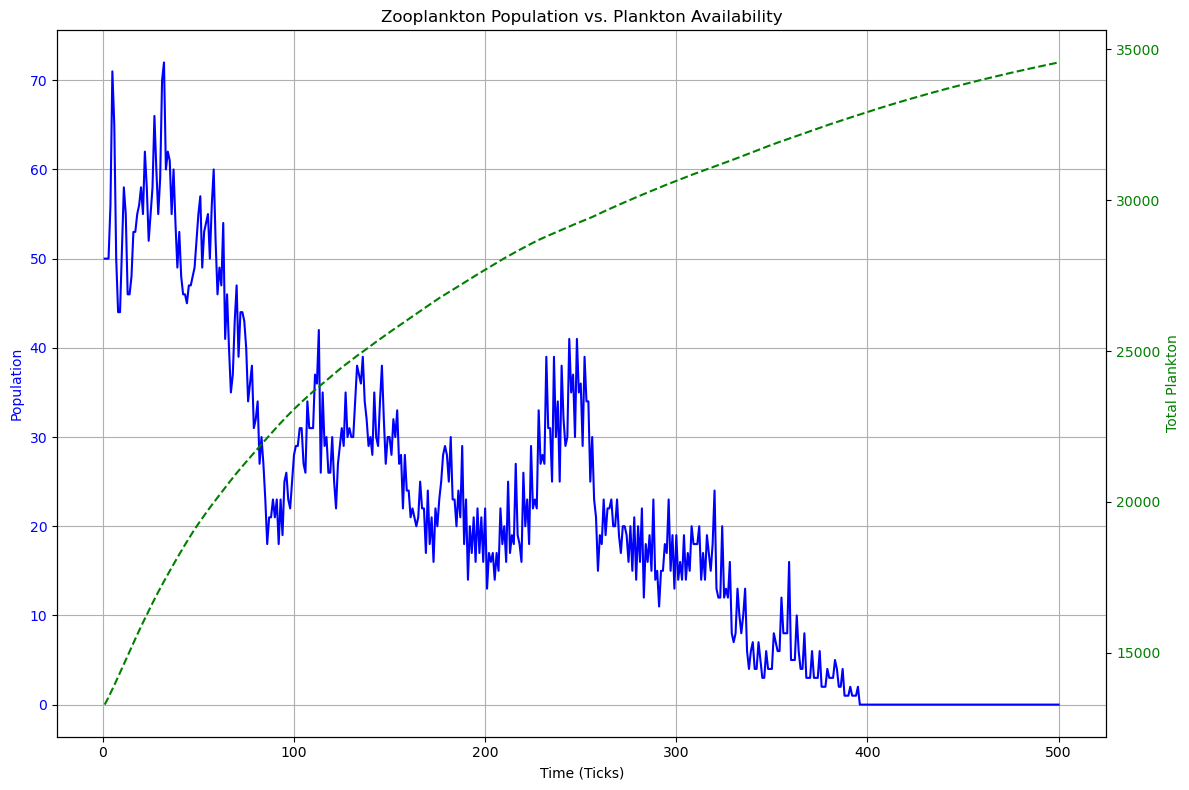

In [4]:
# Extract data from history
ticks = [h['tick'] for h in history]
population = [h['population'] for h in history]
total_plankton = [h['total_plankton'] for h in history]

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(ticks, population, 'b-', label='Zooplankton Population')
ax1.set_xlabel('Time (Ticks)')
ax1.set_ylabel('Population', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Zooplankton Population vs. Plankton Availability')
ax1.grid(True)

ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(ticks, total_plankton, 'g--', label='Total Plankton')
ax2.set_ylabel('Total Plankton', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.show()

## Observation and Conclusion
The data clearly shows the classic **boom-and-bust cycle**, now driven by the more realistic, dynamic plankton environment.

1.  **Boom Phase:** The zooplankton population grows exponentially, consuming the readily available plankton.
2.  **Resource Depletion:** This rapid population growth leads to a sharp decline in the total plankton as it is consumed faster than the Cellular Automata rules can replenish it.
3.  **Bust Phase (Crash):** Once the plankton is scarce, mass starvation occurs, and the zooplankton population crashes.
4.  **Potential for Recovery:** We can see that after the zooplankton population crashes, the plankton level begins to slowly recover, driven by the sunlight and diffusion rules. This demonstrates that the environment is self-regulating and can bounce back from over-consumption.

This outcome successfully validates the interaction between the Particle Life agents and the Cellular Automata environment. The system is stable and produces realistic ecological patterns, making it a solid foundation for the introduction of predators in Phase 3.